<a href="https://colab.research.google.com/github/manujism/Nilesh-Client-Simulations/blob/main/Nilesh_No_Immidiate_Purchase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Font for Rupee symbol (₹) configured successfully.
Loading timeline and SIP schedule from Excel file...
Checking for required Real Estate return columns...
✅ All required Real Estate return columns found.
Using hardcoded financial goals...
Goals loaded: ['2027 - CPL Fees', '2030 - Primary Home Purchase', "2037 - Elder Daughter's Marriage", "2037 - Younger Daughter's Higher Education", "2042 - Younger Daughter's Marriage"]
✅ Data preparation complete.

--- Running 10,000 main simulations for 'Advanced Scenario' ---

[Logging] A detailed log will be generated for random simulation path #1533

########################################################################################################################
###                                   Detailed Monthly Log for a RANDOM Simulation Path                                    ###
########################################################################################################################
           Date Withdrawal Liqu

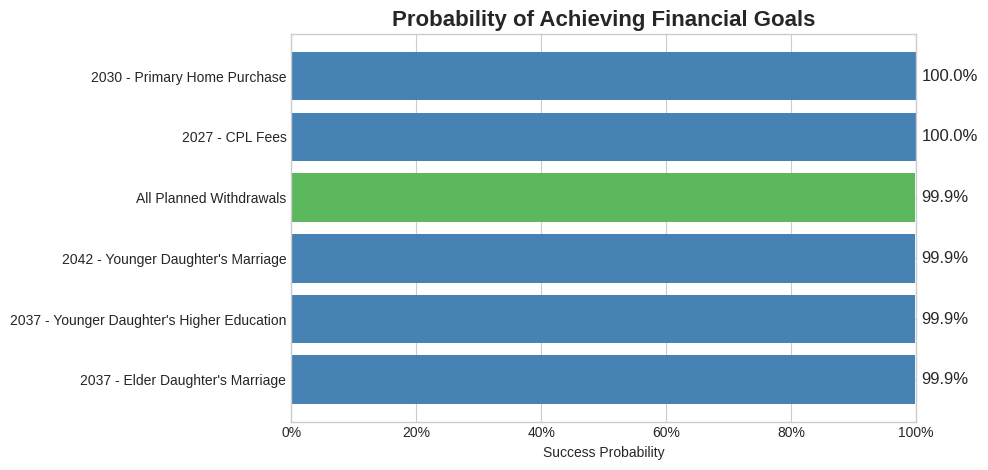

/tmp/ipython-input-1365562139.py:278: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


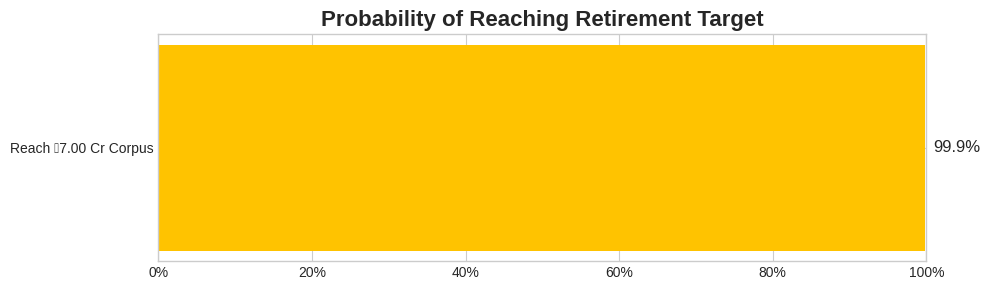

/tmp/ipython-input-1365562139.py:330: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


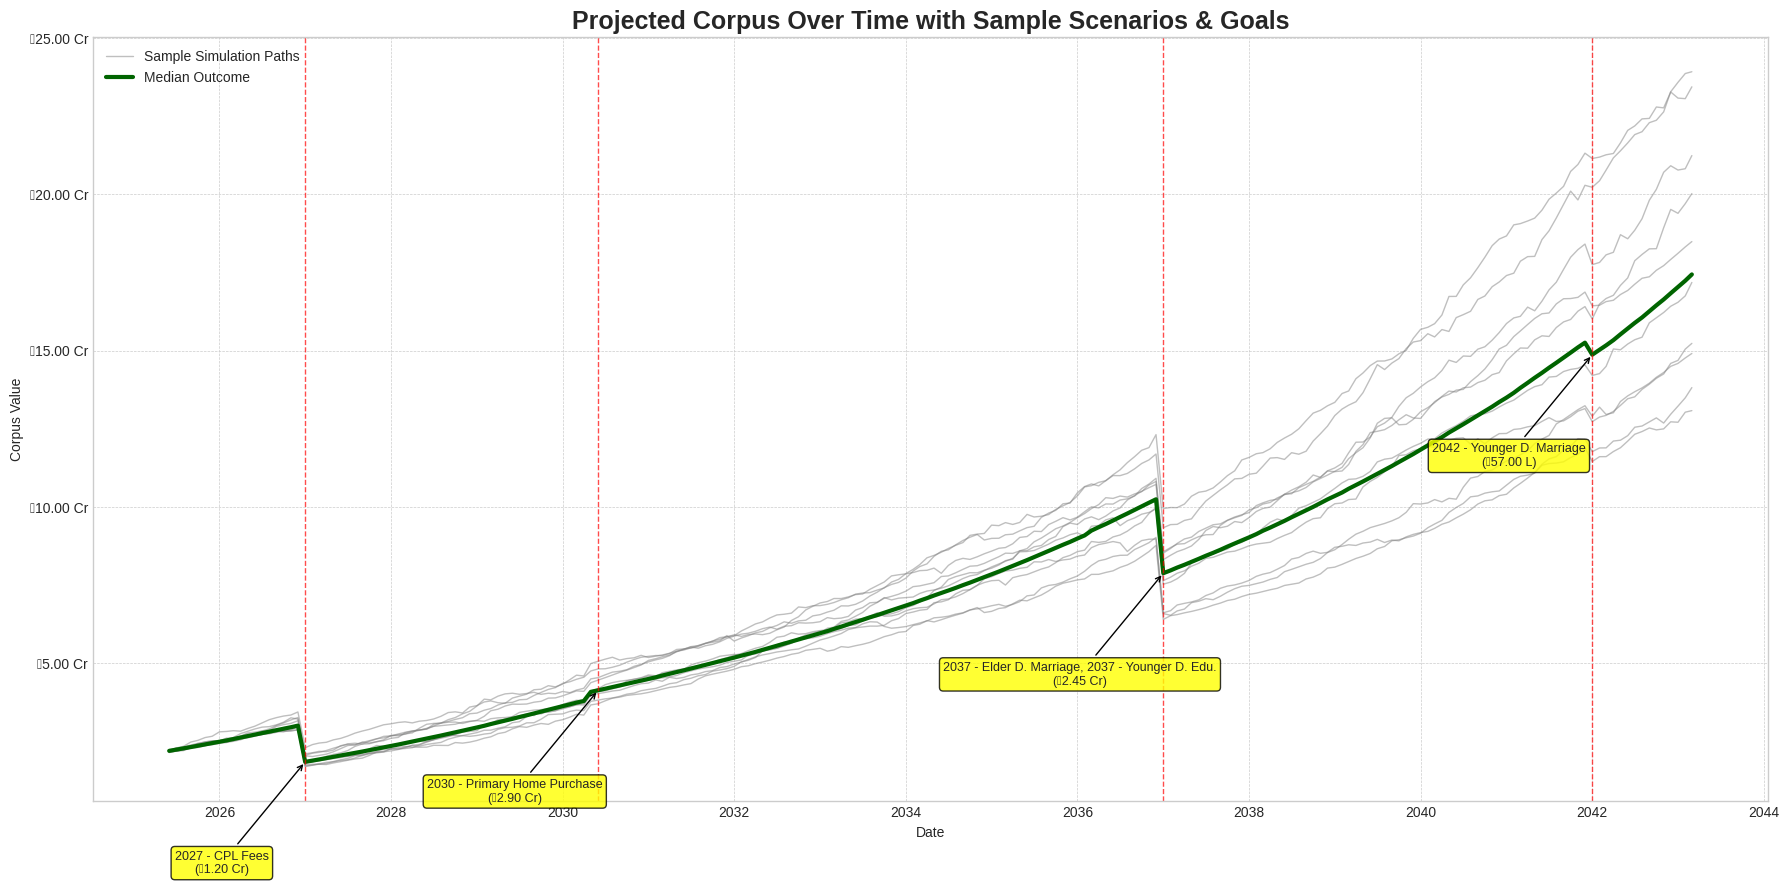

/tmp/ipython-input-1365562139.py:346: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


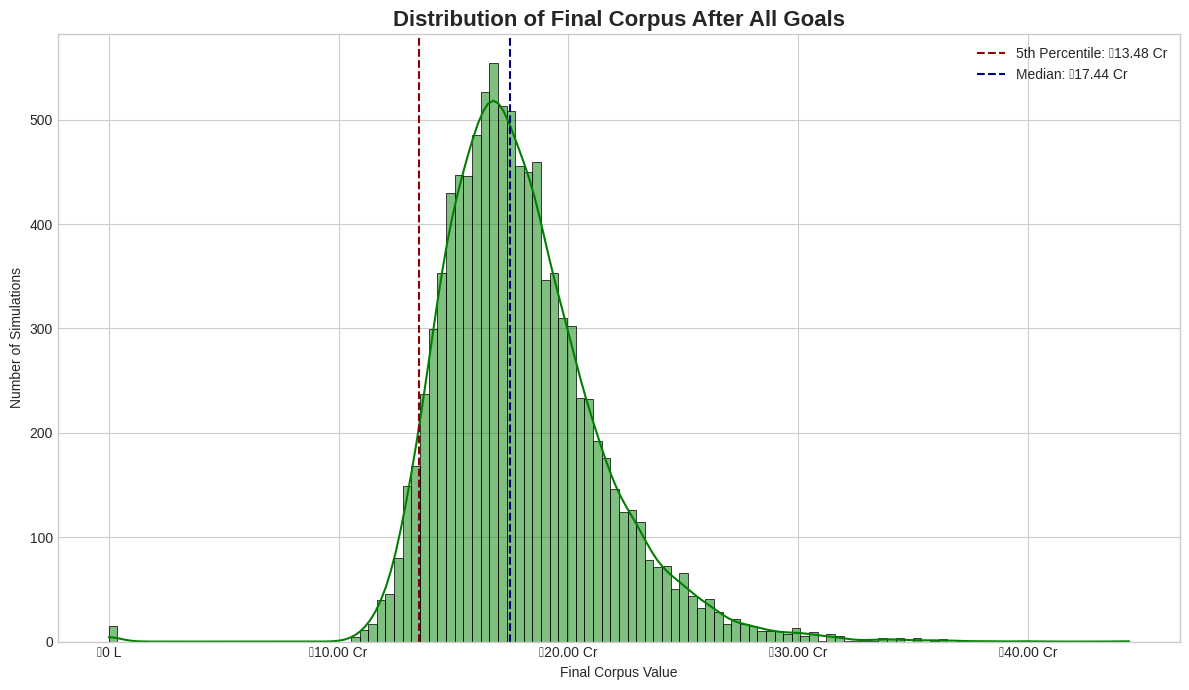


✅ All analyses complete.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from collections import Counter
import io

# --- FIX FOR THE RUPEE SYMBOL (₹) ---
from matplotlib.font_manager import fontManager
import urllib.request

try:
    # Attempt to download and register a font that supports the Rupee symbol
    font_url = 'https://github.com/google/fonts/raw/main/ofl/lohitdevanari/Lohit-Devanagari.ttf'
    font_filename = 'Lohit-Devanagari.ttf'
    if not any(font.fname.endswith(font_filename) for font in fontManager.ttflist):
        urllib.request.urlretrieve(font_url, font_filename)
        fontManager.addfont(font_filename)
        print(f"✅ Font '{font_filename}' downloaded and installed.")
    plt.rcParams['font.family'] = 'Lohit Devanagari'
    print("✅ Font for Rupee symbol (₹) configured successfully.")
except Exception as e:
    print(f"⚠️ Could not download or configure font. Rupee symbol might not display correctly. Error: {e}")
# --- END OF FIX BLOCK ---


# --- Helper function for Crores & Lakhs Formatting ---
def format_indian_currency(num):
    """Converts a number to a string in Indian Crores/Lakhs format."""
    if pd.isna(num) or num == 0:
        return "₹0 L"
    num = float(num)
    sign = "(-)" if num < 0 else ""
    num = abs(num)

    if num >= 1_00_00_000:
        return f"{sign}₹{num / 1_00_00_000:,.2f} Cr"
    else:
        return f"{sign}₹{num / 1_00_000:,.2f} L"

# --- Function to create a detailed summary DataFrame ---
def create_detailed_summary_df(raw_data, dates, goal_df):
    """Creates a detailed month-by-month summary DataFrame from raw simulation data."""
    print("\n--- [Analysis] Generating detailed monthly statistics... ---")
    goal_df_aligned = goal_df.copy()
    if not isinstance(goal_df_aligned.index, pd.DatetimeIndex):
        goal_df_aligned.index = dates
    withdrawals = goal_df_aligned.sum(axis=1).reindex(dates, fill_value=0).values

    summary_data = {
        'Median Corpus': np.percentile(raw_data, 50, axis=0),
        'Mean Corpus': np.mean(raw_data, axis=0),
        'Std Dev': np.std(raw_data, axis=0),
        '5th Percentile': np.percentile(raw_data, 5, axis=0),
        '95th Percentile': np.percentile(raw_data, 95, axis=0),
        'Prob. Corpus > 0': np.mean(raw_data > 0, axis=0),
        'Withdrawals': withdrawals
    }
    summary_df = pd.DataFrame(summary_data, index=dates)
    summary_df.index.name = "Month"
    display_summary_df = summary_df.copy()
    currency_cols = ['Median Corpus', 'Mean Corpus', 'Std Dev', '5th Percentile', '95th Percentile', 'Withdrawals']
    for col in currency_cols:
        display_summary_df[col] = display_summary_df[col].apply(format_indian_currency)
    display_summary_df['Prob. Corpus > 0'] = display_summary_df['Prob. Corpus > 0'].apply(lambda p: f"{p:.1%}")
    return summary_df, display_summary_df

# --- Monte Carlo Simulation Engine ---
def run_simulation(name, initial_corpus_weights, sip_weights, initial_investment, sip_schedule, goal_df, returns_df, num_simulations, dates):
    """Runs a full, multi-path simulation with special real estate handling."""
    print(f"\n--- Running {num_simulations:,} main simulations for '{name}' ---")
    investment_horizon_months = len(sip_schedule)
    goal_columns = goal_df.columns
    base_assets = sorted(list(set(initial_corpus_weights.keys()) | set(sip_weights.keys())))

    all_asset_components = base_assets.copy()
    if 'Real Estate' in all_asset_components:
        all_asset_components.remove('Real Estate')
        # <<< MODIFIED: Added 'Pune_Property' to the list of assets for tracking and logging
        all_asset_components.extend(['Real_Estate_Other', 'Gurugram_Plot1', 'Gurugram_Plot2', 'Pune_Property'])
    all_asset_components = sorted(all_asset_components)

    corpus_over_time_all_sims = np.zeros((num_simulations, investment_horizon_months))
    final_corpus_values = []
    goal_failure_counter = Counter()
    liquidity_failures = 0

    simulation_to_log = np.random.randint(0, num_simulations)
    print(f"\n[Logging] A detailed log will be generated for random simulation path #{simulation_to_log + 1}")
    detailed_log_for_one_sim = []

    for i in range(num_simulations):
        corpus_by_asset = {}
        for asset, weight in initial_corpus_weights.items():
            corpus_by_asset[asset] = initial_investment * weight

        gurugram_plot1_initial = 25_00_000
        gurugram_plot2_initial = 40_00_000
        total_initial_re = corpus_by_asset.get('Real Estate', 0)

        corpus_by_asset['Gurugram_Plot1'] = gurugram_plot1_initial
        corpus_by_asset['Gurugram_Plot2'] = gurugram_plot2_initial
        corpus_by_asset['Real_Estate_Other'] = total_initial_re - (gurugram_plot1_initial + gurugram_plot2_initial)
        # <<< MODIFIED: Initialize the Pune property value to zero at the start of each simulation
        corpus_by_asset['Pune_Property'] = 0

        if 'Real Estate' in corpus_by_asset:
            del corpus_by_asset['Real Estate']

        gurugram_sale_proceeds_in_debt = 0
        has_failed_this_sim = False

        for month in range(investment_horizon_months):
            current_date = dates.iloc[month]
            sip_this_month = sip_schedule[month]
            general_withdrawal_amount = goal_df.iloc[month].sum()

            liquid_assets = ['Debt', 'Flexi Cap Funds', 'Large Cap Index', 'Gold']
            liquid_corpus = sum(corpus_by_asset.get(asset, 0) for asset in liquid_assets)

            liquid_corpus_for_log = liquid_corpus

            is_pune_purchase_month = (current_date.year == 2030 and current_date.month == 6)
            if not is_pune_purchase_month and general_withdrawal_amount > liquid_corpus:
                missed_goals = [goal for goal in goal_columns if goal_df.iloc[month][goal] > 0]
                goal_failure_counter.update(missed_goals)
                if not has_failed_this_sim:
                    liquidity_failures += 1
                has_failed_this_sim = True

            if has_failed_this_sim:
                for asset in list(corpus_by_asset.keys()):
                    corpus_by_asset[asset] = 0
            else:
                if not is_pune_purchase_month and general_withdrawal_amount > 0 and liquid_corpus > 0:
                    reduction_factor = (liquid_corpus - general_withdrawal_amount) / liquid_corpus
                    for asset in liquid_assets:
                        corpus_by_asset[asset] *= reduction_factor

                if sip_this_month > 0:
                    for asset, weight in sip_weights.items():
                        corpus_by_asset[asset] = corpus_by_asset.get(asset, 0) + (sip_this_month * weight)

                if current_date.year == 2030 and current_date.month == 1:
                    gurugram_sale_proceeds_in_debt = corpus_by_asset.get('Gurugram_Plot1', 0) + corpus_by_asset.get('Gurugram_Plot2', 0)
                    corpus_by_asset['Debt'] += gurugram_sale_proceeds_in_debt
                    corpus_by_asset['Gurugram_Plot1'] = 0
                    corpus_by_asset['Gurugram_Plot2'] = 0

                if is_pune_purchase_month:
                    pune_plot_price = general_withdrawal_amount
                    funds_needed = pune_plot_price
                    taken_from_gurugram_proceeds = min(funds_needed, gurugram_sale_proceeds_in_debt)
                    corpus_by_asset['Debt'] -= taken_from_gurugram_proceeds
                    gurugram_sale_proceeds_in_debt -= taken_from_gurugram_proceeds
                    funds_needed -= taken_from_gurugram_proceeds

                    if funds_needed > 0:
                        remaining_liquid_corpus = sum(corpus_by_asset.get(asset, 0) for asset in liquid_assets)
                        if remaining_liquid_corpus > 0:
                            reduction_factor = max(0, (remaining_liquid_corpus - funds_needed) / remaining_liquid_corpus)
                            for asset in liquid_assets:
                                corpus_by_asset[asset] *= reduction_factor
                    # <<< MODIFIED: The purchased property value is now correctly assigned to 'Pune_Property'
                    corpus_by_asset['Pune_Property'] = pune_plot_price

                # <<< MODIFIED: This entire block is updated for specific real estate returns
                random_returns_row = returns_df.sample(1).iloc[0]
                for asset in list(corpus_by_asset.keys()):
                    asset_return = 0
                    if asset == 'Gurugram_Plot1' or asset == 'Gurugram_Plot2':
                        asset_return = random_returns_row.get('Gurugram Real Estate', 0)
                    elif asset == 'Real_Estate_Other':
                        asset_return = random_returns_row.get('Nagpur Real Estate', 0)
                    # <<< MODIFIED: Added logic to apply Pune-specific returns to the Pune property
                    elif asset == 'Pune_Property':
                        asset_return = random_returns_row.get('Pune Real Estate', 0)
                    else:
                        asset_return = random_returns_row.get(asset, 0)

                    if asset in corpus_by_asset:
                        corpus_by_asset[asset] *= (1 + asset_return / 100.0)
                # <<< END OF MODIFIED BLOCK

            if i == simulation_to_log:
                total_corpus_after_actions = sum(corpus_by_asset.values())
                log_entry = {
                    'Date': current_date.strftime('%Y-%m-%d'), 'Withdrawal': general_withdrawal_amount,
                    'Liquid_Corpus': liquid_corpus_for_log, 'Total_Corpus': total_corpus_after_actions
                }
                for asset in all_asset_components:
                    log_entry[f'{asset}_Value'] = corpus_by_asset.get(asset, 0)
                for asset in all_asset_components:
                    allocation = (corpus_by_asset.get(asset, 0) / total_corpus_after_actions) * 100 if total_corpus_after_actions > 0 else 0
                    log_entry[f'{asset}_Allocation_%'] = allocation
                detailed_log_for_one_sim.append(log_entry)

            corpus_over_time_all_sims[i, month] = sum(corpus_by_asset.values())

        final_total_corpus = sum(corpus_by_asset.values())
        final_corpus_values.append(final_total_corpus if final_total_corpus >= 0 else 0)

    prob_all_goals = 1 - (liquidity_failures / num_simulations)
    goal_success_prob = {goal: 1 - (goal_failure_counter.get(goal, 0) / num_simulations) for goal in goal_columns if goal_df[goal].sum() > 0}

    print("\n" + "#"*120)
    print("###" + " "*35 + "Detailed Monthly Log for a RANDOM Simulation Path" + " "*36 + "###")
    print("#"*120)
    if detailed_log_for_one_sim:
        detailed_df = pd.DataFrame(detailed_log_for_one_sim)
        display_df = detailed_df.copy()
        value_cols = [col for col in display_df.columns if '_Value' in col or 'Corpus' in col or 'Withdrawal' in col]
        for col in value_cols:
            display_df[col] = display_df[col].apply(format_indian_currency)
        alloc_cols = [col for col in display_df.columns if '_Allocation_%' in col]
        for col in alloc_cols:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}%")
        ordered_cols = ['Date', 'Withdrawal', 'Liquid_Corpus', 'Total_Corpus']
        for asset in sorted(all_asset_components):
            ordered_cols.append(f'{asset}_Value')
        for asset in sorted(all_asset_components):
            ordered_cols.append(f'{asset}_Allocation_%')
        display_df = display_df[ordered_cols]
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 2500):
            print(display_df)


    return {
        'name': name, 'prob_all_goals': prob_all_goals, 'median_corpus': np.median(final_corpus_values),
        '5th_percentile_corpus': np.percentile(final_corpus_values, 5), 'final_corpus_values': final_corpus_values,
        'goal_success_prob': goal_success_prob, 'raw_corpus_data': corpus_over_time_all_sims
    }

# --- Visualization Functions (No changes needed here) ---
def plot_goal_probabilities(goal_probs):
    """Plots the success probabilities for all goals."""
    plt.style.use('seaborn-v0_8-whitegrid')
    if not goal_probs:
        print("No goal probabilities to plot.")
        return

    labels = list(goal_probs.keys())
    probs = list(goal_probs.values())
    sorted_pairs = sorted(zip(probs, labels), reverse=True)
    probs, labels = zip(*sorted_pairs)

    fig, ax = plt.subplots(figsize=(10, max(4, len(labels) * 0.8)))
    colors = ['#5cb85c' if 'All' in label else '#4682B4' for label in labels]
    bars = ax.barh(labels, probs, color=colors)
    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.set_title('Probability of Achieving Financial Goals', fontsize=16, weight='bold')
    ax.set_xlabel('Success Probability')

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.1%}', ha='left', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_retirement_goal_probability(prob, target_corpus):
    """Plots the probability of reaching a specific retirement corpus target."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 3))
    label = f"Reach {format_indian_currency(target_corpus)} Corpus"
    bars = ax.barh([label], [prob], color='#FFC300')
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.set_title('Probability of Reaching Retirement Target', fontsize=16, weight='bold')

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.1%}', ha='left', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

def plot_corpus_projections(results, dates, goal_df):
    """Creates a chart showing the median outcome, several individual simulation paths, and goal annotations."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(18, 9))

    raw_data = results['raw_corpus_data']
    p50_median = np.percentile(raw_data, 50, axis=0)

    num_paths_to_show = 10
    num_simulations = raw_data.shape[0]
    if num_paths_to_show > num_simulations:
        num_paths_to_show = num_simulations

    path_indices = np.random.choice(num_simulations, size=num_paths_to_show, replace=False)

    for i, path_index in enumerate(path_indices):
        label = "Sample Simulation Paths" if i == 0 else None
        plt.plot(dates, raw_data[path_index, :], color='grey', alpha=0.5, linewidth=1.0, label=label)

    plt.plot(dates, p50_median, label="Median Outcome", color='darkgreen', linewidth=3.0)

    withdrawals = goal_df.sum(axis=1)
    major_goals = withdrawals[withdrawals > 0]

    for date, amount in major_goals.items():
        goal_names = goal_df.columns[goal_df.loc[date] > 0].tolist()
        clean_names = [name.replace("'s", "").replace("Daughter", "D.").replace("Higher Education", "Edu.") for name in goal_names]
        label_text = f"{', '.join(clean_names)}\n({format_indian_currency(amount)})"

        plt.axvline(x=date, color='red', linestyle='--', linewidth=1, alpha=0.7)

        y_position = np.interp(date.to_numpy().astype(np.int64),
                                   dates.to_numpy().astype(np.int64),
                                   p50_median)

        plt.annotate(label_text,
                     xy=(date, y_position),
                     xytext=(-60, -80),
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", color='black'),
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.8),
                     ha='center', fontsize=9)

    plt.title('Projected Corpus Over Time with Sample Scenarios & Goals', fontsize=18, weight='bold')
    plt.ylabel('Corpus Value')
    plt.xlabel('Date')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_indian_currency(y)))
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_final_corpus_distribution(results):
    plt.figure(figsize=(12, 7))
    final_values = results['final_corpus_values']
    plt.title('Distribution of Final Corpus After All Goals', fontsize=16, weight='bold')
    plt.xlabel('Final Corpus Value')
    plt.ylabel('Number of Simulations')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_indian_currency(x)))
    sns.histplot(data=final_values, kde=True, fill=True, color='green')
    median_val = results['median_corpus']
    p5_val = results['5th_percentile_corpus']
    plt.axvline(p5_val, color='darkred', linestyle='--', linewidth=1.5, label=f'5th Percentile: {format_indian_currency(p5_val)}')
    plt.axvline(median_val, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {format_indian_currency(median_val)}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Main Execution Block ---
def main():
    CLIENT_DATA_FILE = 'No immidiate purchase.xlsx'
    RETURNS_FILE = 'Nilesh - Returns.xlsx'

    try:
        print("Loading timeline and SIP schedule from Excel file...")
        client_data_df = pd.read_excel(CLIENT_DATA_FILE)
        returns_df = pd.read_excel(RETURNS_FILE, sheet_name='Sheet2')
        returns_df.columns = returns_df.columns.str.strip()

        # <<< MODIFIED: Check for all three required real estate columns
        print("Checking for required Real Estate return columns...")
        required_re_cols = ['Gurugram Real Estate', 'Nagpur Real Estate', 'Pune Real Estate']
        missing_cols = [col for col in required_re_cols if col not in returns_df.columns]
        if missing_cols:
            raise ValueError(f"ERROR: Missing required columns in '{RETURNS_FILE}': {', '.join(missing_cols)}")
        print("✅ All required Real Estate return columns found.")
        # <<< END OF MODIFIED BLOCK

        client_data_df['Month'] = pd.to_datetime(client_data_df['Month'])
        dates = client_data_df['Month']
        sip_schedule = pd.to_numeric(client_data_df['Total Investment'], errors='coerce').fillna(0).values

        print("Using hardcoded financial goals...")
        hardcoded_goals_data = {
            '2027 - CPL Fees': ('2027-01-01', 1_20_00_000),
            '2030 - Primary Home Purchase': ('2030-06-01', 2_90_00_000),
            "2037 - Elder Daughter's Marriage": ('2037-01-01', 45_00_000),
            "2037 - Younger Daughter's Higher Education": ('2037-01-01', 2_00_00_000),
            "2042 - Younger Daughter's Marriage": ('2042-01-01', 57_00_000)
        }

        goal_df = pd.DataFrame(0, index=dates, columns=hardcoded_goals_data.keys())

        for goal_name, (goal_date_str, goal_amount) in hardcoded_goals_data.items():
            goal_date = pd.to_datetime(goal_date_str)
            if goal_date in goal_df.index:
                goal_df.loc[goal_date, goal_name] = goal_amount
            else:
                print(f"Warning: Goal date {goal_date_str} for '{goal_name}' not found in timeline. Goal ignored.")

        print(f"Goals loaded: {list(hardcoded_goals_data.keys())}")

        goal_order = sorted(
            goal_df.columns, key=lambda g: goal_df[g].ne(0).idxmax() if goal_df[g].sum() > 0 else pd.Timestamp.max
        )
        goal_df = goal_df[goal_order]
        print("✅ Data preparation complete.")

        initial_investment = 21428380
        num_simulations = 10000
        initial_corpus_weights = {
            'Real Estate': 0.4434, 'Debt': 0.3221, 'Flexi Cap Funds': 0.10745,
            'Large Cap Index': 0.10745, 'Gold': 0.0196
        }
        sip_weights = {
            'Flexi Cap Funds': 0.30, 'Large Cap Index': 0.20, 'Debt': 0.25, 'Gold': 0.25
        }

        results = run_simulation(
            "Advanced Scenario", initial_corpus_weights, sip_weights, initial_investment,
            sip_schedule, goal_df, returns_df, num_simulations, dates
        )

        print("\n\n" + "#"*80)
        print("###" + " "*27 + "SIMULATION ANALYSIS" + " "*28 + "###")
        print("#"*80)
        print(f"\nOverall Success Probability (All Withdrawals Met): {results['prob_all_goals']:.1%}")
        print(f"Median Final Corpus (Typical Outcome): {format_indian_currency(results['median_corpus'])}")
        print(f"Worst-Case Corpus (5th Percentile): {format_indian_currency(results['5th_percentile_corpus'])}")

        retirement_goal = 7_00_00_000
        final_values = np.array(results['final_corpus_values'])
        prob_of_7cr = np.mean(final_values >= retirement_goal)
        print(f"\nProbability of Final Corpus >= {format_indian_currency(retirement_goal)}: {prob_of_7cr:.1%}")

        all_goal_probs_for_plot = {'All Planned Withdrawals': results['prob_all_goals']}
        all_goal_probs_for_plot.update(results['goal_success_prob'])

        raw_summary_df, display_summary_df = create_detailed_summary_df(
            results['raw_corpus_data'], dates, goal_df
        )

        print("\n--- Summary Statistics (First 12 Months) ---")
        print(display_summary_df.head(12))
        print("\n--- Summary Statistics (Last 12 Months) ---")
        print(display_summary_df.tail(12))

        SUMMARY_FILE_NAME = 'detailed_monthly_summary.csv'
        raw_summary_df.to_csv(SUMMARY_FILE_NAME)
        print(f"\n✅ Full detailed summary saved to '{SUMMARY_FILE_NAME}'")

        print("\n\n" + "#"*80)
        print("###" + " "*29 + "GENERATING VISUALS" + " "*30 + "###")
        print("#"*80)
        plot_goal_probabilities(all_goal_probs_for_plot)
        plot_retirement_goal_probability(prob_of_7cr, retirement_goal)
        plot_corpus_projections(results, dates, goal_df)
        plot_final_corpus_distribution(results)
        print("\n✅ All analyses complete.")

    except FileNotFoundError as e:
        print(f"\n❌ ERROR: Data file not found. Make sure '{e.filename}' is in the same directory.")
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == '__main__':
    main()